In [84]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [159]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [160]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "SelectedSkin",
    shuffle=True, 
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 10412 files belonging to 6 classes.


In [161]:
class_names = dataset.class_names
class_names

['AtopicDermatitis',
 'Eczema',
 'HealthySkin',
 'PsoriasisLichenPlanus',
 'Seborrheic Keratoses',
 'WartsMolluscum']

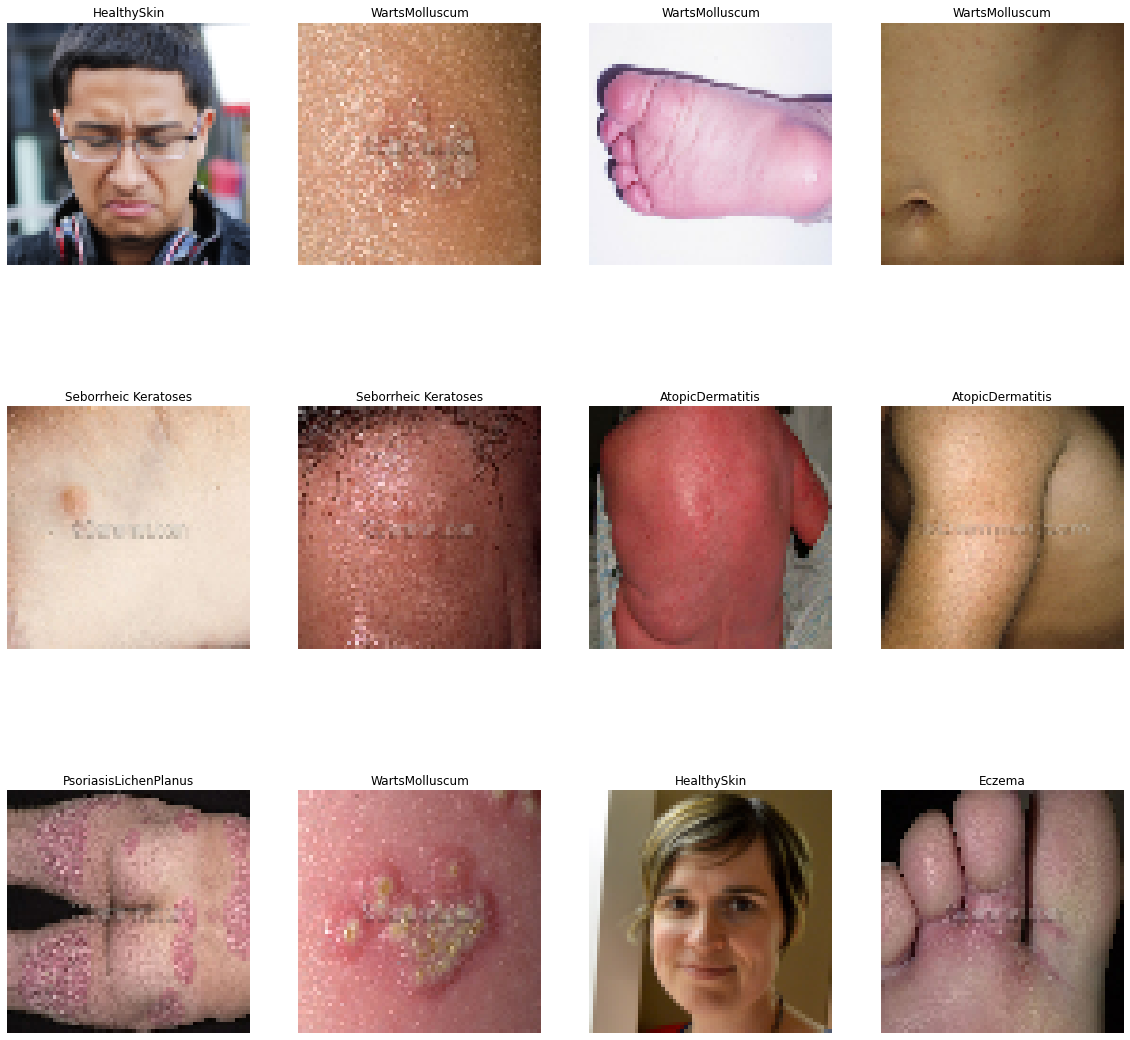

In [162]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 
    

In [163]:
len(dataset) 

326

In [164]:
train_size = 0.8
len(dataset)*train_size 

260.8

In [165]:
train_ds= dataset.take(260) 
len(train_ds)

260

In [166]:
test_ds = dataset.skip(260) 
len(test_ds)

66

In [167]:
val_size=0.1
len(dataset)*val_size

32.6

In [168]:
val_ds = test_ds.take(32)
len(val_ds)

32

In [169]:
test_ds = test_ds.skip(32)
len(test_ds)

34

In [170]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    
    train_ds = ds.take(train_size)
    
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [171]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [172]:
len(train_ds)

260

In [173]:
len(val_ds)

32

In [174]:
len(test_ds)

34

In [175]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [176]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [177]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])



In [224]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(),
    layers.Dense(460, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), 
])
model.build(input_shape=input_shape)

In [225]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_27 (Sequential)   (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_28 (Sequential)   (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (32, 62, 62, 32)          896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (32, 31, 31, 32)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (32, 29, 29, 64)          18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (32, 14, 14, 64)          0         
_________________________________________________________________
flatten_29 (Flatten)         (32, 12544)             

In [226]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [227]:
history = model.fit(
    
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
260/260 [==============================] - 30s 113ms/step - loss: 1.5006 - accuracy: 0.3877 - val_loss: 1.3298 - val_accuracy: 0.4229
Epoch 2/50
260/260 [==============================] - 29s 113ms/step - loss: 1.2870 - accuracy: 0.4625 - val_loss: 1.1991 - val_accuracy: 0.5059
Epoch 3/50
260/260 [==============================] - 30s 114ms/step - loss: 1.2306 - accuracy: 0.4865 - val_loss: 1.1453 - val_accuracy: 0.5186
Epoch 4/50
260/260 [==============================] - 33s 126ms/step - loss: 1.1880 - accuracy: 0.5006 - val_loss: 1.1026 - val_accuracy: 0.5439
Epoch 5/50
260/260 [==============================] - 31s 120ms/step - loss: 1.1653 - accuracy: 0.5087 - val_loss: 1.0970 - val_accuracy: 0.5439
Epoch 6/50
260/260 [==============================] - 30s 114ms/step - loss: 1.1454 - accuracy: 0.5123 - val_loss: 1.0531 - val_accuracy: 0.5596
Epoch 7/50
260/260 [==============================] - 30s 116ms/step - loss: 1.1310 - accuracy: 0.5276 - val_loss: 1.0603 - val_ac

In [229]:
scores = model.evaluate(test_ds)

34/34 [==============================] - 1s 22ms/step - loss: 0.8047 - accuracy: 0.7050


In [230]:
scores

[0.8046541810035706, 0.704963207244873]

In [231]:
history

In [232]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 260}

In [233]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [234]:
history.history['accuracy']

[0.387710839509964,
 0.46253010630607605,
 0.48650601506233215,
 0.5006024241447449,
 0.508674681186676,
 0.5122891664505005,
 0.5275903344154358,
 0.533253014087677,
 0.5308433771133423,
 0.5478312969207764,
 0.5475903749465942,
 0.5540964007377625,
 0.558313250541687,
 0.5608433485031128,
 0.575542151927948,
 0.5722891688346863,
 0.582168698310852,
 0.5933734774589539,
 0.5937349200248718,
 0.5933734774589539,
 0.6065060496330261,
 0.6073493957519531,
 0.6090361475944519,
 0.6118072271347046,
 0.6179518103599548,
 0.6293975710868835,
 0.6278313398361206,
 0.6442168951034546,
 0.633855402469635,
 0.6438553929328918,
 0.6383132338523865,
 0.6573494076728821,
 0.6583132743835449,
 0.666746973991394,
 0.6697590351104736,
 0.6718072295188904,
 0.6708433628082275,
 0.6737349629402161,
 0.6824096441268921,
 0.6873493790626526,
 0.6910843253135681,
 0.6910843253135681,
 0.691686749458313,
 0.7054216861724854,
 0.7098795175552368,
 0.716265082359314,
 0.7161445617675781,
 0.717108428478241,
 

In [235]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

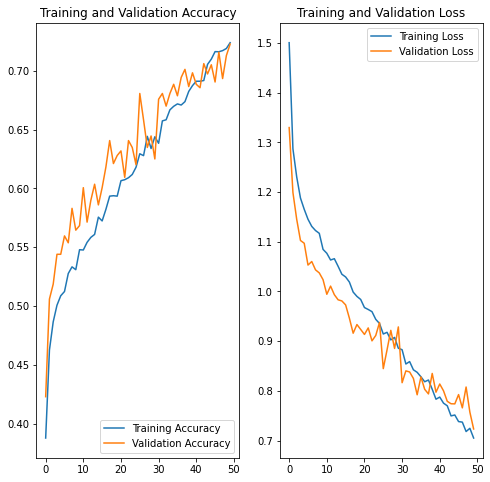

In [549]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to Predict
actual label: HealthySkin
predicted label: HealthySkin


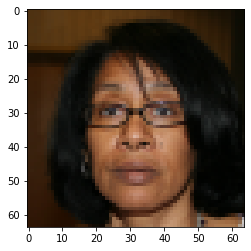

In [237]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image =images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to Predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [238]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])),2)
    return predicted_class, confidence

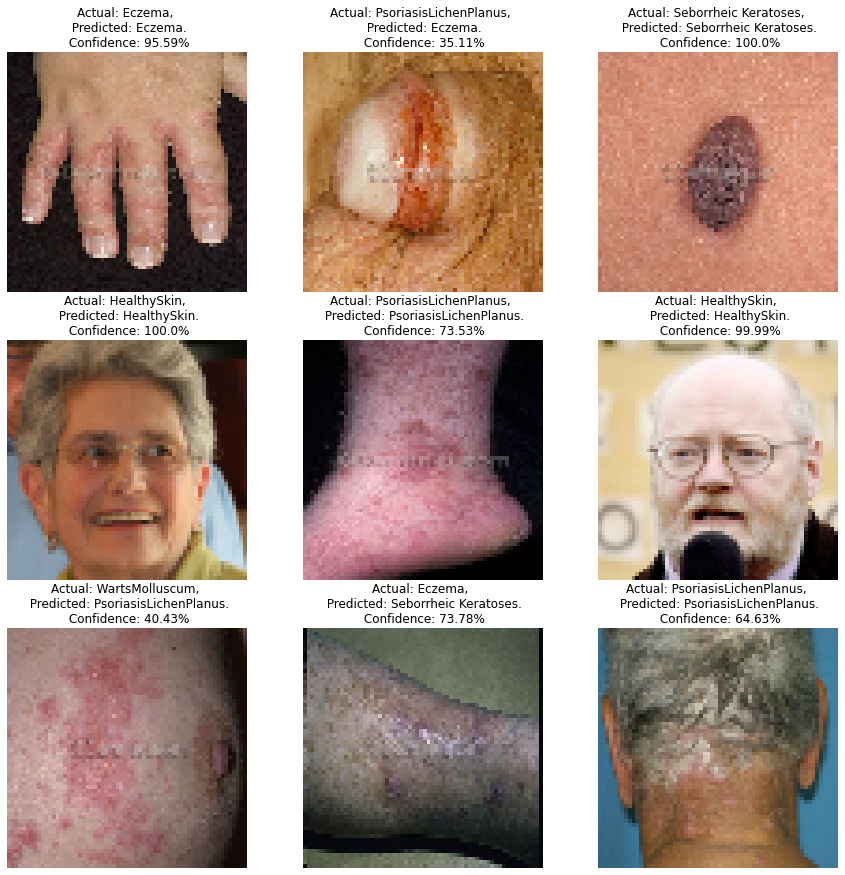

In [269]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [522]:
train_ds

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [523]:
test_ds

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [524]:
val_ds

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [518]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


In [533]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    
    
    
    
    batch_prediction = model.predict(images_batch)
    

In [528]:
for i in batch_prediction:
    print(i)

[7.3468357e-02 1.8732151e-02 5.3994389e-11 3.5340711e-02 5.5437521e-03
 8.6691505e-01]
[0.05215102 0.5471331  0.00150158 0.26079017 0.10560045 0.0328237 ]
[8.93734978e-04 1.36433903e-03 1.20355135e-05 2.86820050e-05
 5.18757861e-06 9.97695982e-01]
[1.3574013e-03 8.9496821e-01 7.8566103e-13 1.0367358e-01 5.5648632e-09
 7.6605738e-07]
[1.8537803e-02 4.5439349e-03 4.3836981e-06 1.2801756e-01 3.0282897e-01
 5.4606736e-01]
[2.6786604e-03 9.8704612e-01 7.4877889e-11 9.0064961e-05 7.9466425e-09
 1.0185215e-02]
[1.8088285e-20 6.9359917e-18 1.0000000e+00 1.2638519e-17 1.7531321e-25
 1.2410870e-16]
[0.00614309 0.01008604 0.00353969 0.08186359 0.01948718 0.87888044]
[2.5549617e-01 2.7812299e-01 1.6319360e-06 1.5399086e-01 2.3898445e-02
 2.8848988e-01]
[0.90772796 0.0031006  0.0258916  0.02805577 0.00114896 0.03407511]
[5.5326770e-20 2.8640106e-23 1.0000000e+00 1.1200343e-19 1.1224193e-22
 9.5424064e-21]
[2.1417667e-05 5.4268068e-05 2.9985497e-08 8.8431966e-04 9.8567605e-01
 1.3363925e-02]
[4.5779

In [548]:

    cm = confusion_matrix(y_true=val_ds, y_pred=batch_prediction)

ValueError: Expected array-like (array or non-string sequence), got <PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [438]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['no_side_effects','had_side_effects']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')